In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import matplotlib.pyplot as plt
import time
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from einops import rearrange
from matplotlib.colors import ListedColormap
from methods.metaloss.models.transformer_segmenter import MultiResSegmenter
from methods.metaloss.losses.metaloss import compute_meta_loss
from methods.metaloss.image_utils import convert_1d_index_to_2d, convert_scale_to_coords_in_full_res, convert_1d_patched_index_to_2d_org_index


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
#train_folder = '/media/david/T7/Kvasir-SEG/train'
#val_folder = '/media/david/T7/Kvasir-SEG/validation'
#test_folder = '/media/david/T7/Kvasir-SEG/test'
train_folder = r'D:\Datasets\Kvasir-SEG\train'
val_folder = r'D:\Datasets\Kvasir-SEG\validation'
test_folder = r'D:\Datasets\Kvasir-SEG\test'


In [4]:
def kvasir_data_to_dict(folder):
    images = os.listdir(os.path.join(folder, 'images'))
    data_list_dict = []
    for i in images:
        try:     
            if os.path.exists(os.path.join(folder, 'masks', i)):
                data_dict = {'image': os.path.join(folder, 'images', i),
                             'label': os.path.join(folder, 'masks', i)}
                data_list_dict.append(data_dict)
        except Exception as e:
            print("Failed to find label file {} with exception {}".format(i, e))
    
    return data_list_dict
    

In [5]:
train_data = kvasir_data_to_dict(train_folder)
val_data = kvasir_data_to_dict(val_folder)
test_data = kvasir_data_to_dict(test_folder)
#subtrahend=[142.12, 82.04, 60.13], divisor=[20.95, 11.46, 12.36]


In [6]:
transform_list = [monai.transforms.LoadImaged(keys=['image', 'label']),
              monai.transforms.EnsureChannelFirstD(keys=['image', "label"]),
              monai.transforms.NormalizeIntensityd(keys=['image'], divisor=[255, 255, 255], channel_wise=True),
              monai.transforms.ScaleIntensityRanged(keys=['label'], a_min=0, a_max=255, b_min=0, b_max=1,clip=True),
              #monai.transforms.BorderPadd(keys=['image', 'label'], spatial_border=80),
              monai.transforms.Resized(keys=["image"], spatial_size=(512, 512), mode='bilinear'),
              monai.transforms.Resized(keys=["label"], spatial_size=(512, 512), mode='nearest'),
              monai.transforms.ToTensord(keys=["image", "label"])]
transforms = monai.transforms.Compose(transform_list)

train_dataset = monai.data.Dataset(train_data, transform=transforms)
val_dataset = monai.data.Dataset(val_data, transform=transforms)

In [7]:
data_loader_val = monai.data.DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True
    )

data_loader_train = monai.data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=8,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True
    )

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def visualize_data(im, lab):
    plt.figure()
    if im is not None:
        if im.shape[0] < 4:
            im = im.permute(1, 2, 0)
        if im.min() < 0:
            im += abs(im.min())
        plt.imshow(im.squeeze().cpu().numpy())
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    else:
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none')

In [10]:
def visualize_patches_scale(patches_scale_coords, n_scales, initial_patch_size, image_size, org_image=None, labels=None):
    colormap = ListedColormap(['silver', 'chocolate', 'blue', 'green', 'orange', 'magenta', 'red', 'lime'])
    full_image = torch.zeros(image_size[0] * image_size[1])
    for scale in range(n_scales):
        patch_size = initial_patch_size // 2**scale
        indx_curr_scale = patches_scale_coords[:, 0] == scale
        coords_at_curr_scale = patches_scale_coords[indx_curr_scale, 1]
        coords_at_org_scale = convert_scale_to_coords_in_full_res(coords_at_curr_scale, patch_size, image_size[0])
        full_image[coords_at_org_scale] = scale
    full_image = full_image.view(image_size[0], image_size[1])
    if org_image is not None:
        if org_image.shape[0] < 4:
            org_image = org_image.permute(1, 2, 0)
        plt.imshow(org_image.squeeze().cpu().numpy(), cmap='gray')
    if labels is not None:
        plt.imshow(labels.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    plt.imshow(full_image.squeeze().cpu().numpy(), interpolation='none', alpha=0.9, cmap=colormap)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2879146].


torch.Size([3, 512, 512])


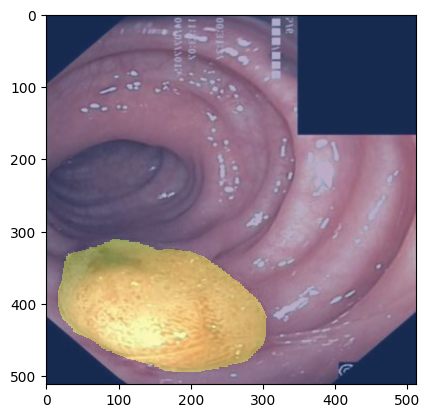

In [11]:
out = data_loader_train.dataset.__getitem__(246)
example_inputs = out['image']
example_labels = out['label']
example_inputs = example_inputs.to(device, non_blocking=True)
example_labels = example_labels.to(device, non_blocking=True)
print(example_inputs.shape)
visualize_data(example_inputs, example_labels)

In [12]:
def create_oracle_labels(labels, patch_size): 
    max = F.max_pool2d(labels.float(), patch_size, stride=patch_size).to(torch.int32)
    min = F.max_pool2d(-labels.float(), patch_size, stride=patch_size).to(torch.int32)
    one_class = (max == -min)
    
    patch_groups_per_img = one_class.to(torch.uint8)
    
    return patch_groups_per_img.to(torch.uint8).squeeze(0)

torch.Size([16, 16])
torch.Size([32, 32])
torch.Size([64, 64])


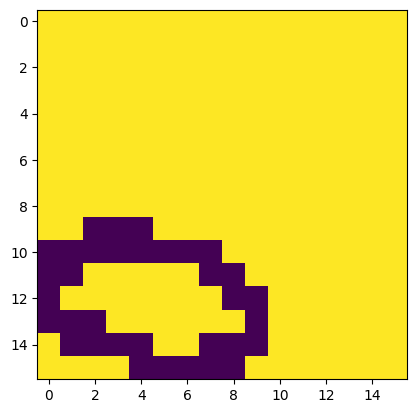

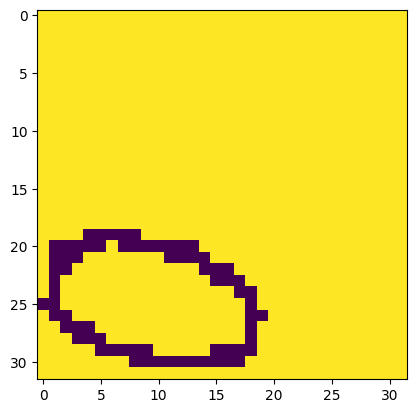

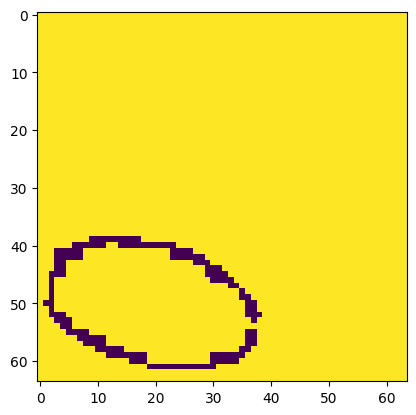

In [13]:
patch_sizes_used = [32, 16, 8]
oracle_labels_multires = []
for ps in patch_sizes_used:
    ol = create_oracle_labels(example_labels, ps)
    oracle_labels_multires.append(ol)
    visualize_data(None, ol)
    print(ol.shape)
    #print(ol.sum())


#oracle_labels = create_oracle_labels(labels, 64)
#visualize_data(inputs, oracle_labels)

In [14]:
d_encoder = [128, 64, 32]
n_heads_encoder = [8, 8, 8]
n_encoder_layers = [8, 8, 8]
d_decoder = 32
n_decoder_layers = 8
patch_size = patch_sizes_used[0]
grad_accum_steps = 1
image_size = (example_inputs.shape[1], example_inputs.shape[2])

model = MultiResSegmenter(image_size=image_size,
                          patch_size=patch_size,
                          channels=3,
                          n_layers_encoder=n_encoder_layers,
                          d_encoder=d_encoder,
                          n_heads_encoder=n_heads_encoder,
                          n_layers_decoder=n_decoder_layers,
                          d_decoder=d_decoder,
                          n_heads_decoder=2,
                          n_scales=len(patch_sizes_used),
                          n_cls=2)

model = model.to(device)
print(model)
print("Total parameters: {}".format(count_parameters(model)))
print("Encoder parameters: {}".format(count_parameters(model.encoder)))
print("Decoder parameters: {}".format(count_parameters(model.decoder)))

MultiResSegmenter(
  (encoder): VisionTransformer(
    (patch_embed): OverlapPatchEmbedding(
      (conv_layers): Sequential(
        (0): DownSampleConvBlock(
          (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (relu): LeakyReLU(negative_slope=0.01)
        )
        (1): DownSampleConvBlock(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (relu): LeakyReLU(negative_slope=0.01)
        )
        (2): DownSampleConvBlock(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (relu): LeakyReLU(negative_slope=0.01)
        )
   

Train Epoch: 0, Dice score: 0.3356, dice_ce_loss: 1.1832, meta_loss: 0.5086, lr: 0.0001, epoch_time: 103.2736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3362954].


Validation - Dice score: 0.4717
Train Epoch: 1, Dice score: 0.3985, dice_ce_loss: 0.8920, meta_loss: 1.0925, lr: 0.0001, epoch_time: 43.0448


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3362954].


Validation - Dice score: 0.4694
Train Epoch: 2, Dice score: 0.4226, dice_ce_loss: 0.8032, meta_loss: 0.8864, lr: 0.0001, epoch_time: 38.8898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3362954].


Validation - Dice score: 0.4824
Train Epoch: 3, Dice score: 0.4368, dice_ce_loss: 0.7923, meta_loss: 0.4502, lr: 0.0001, epoch_time: 31.2035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3362954].


Validation - Dice score: 0.4915


KeyboardInterrupt: 

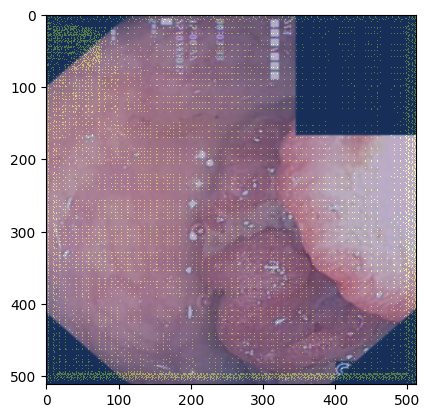

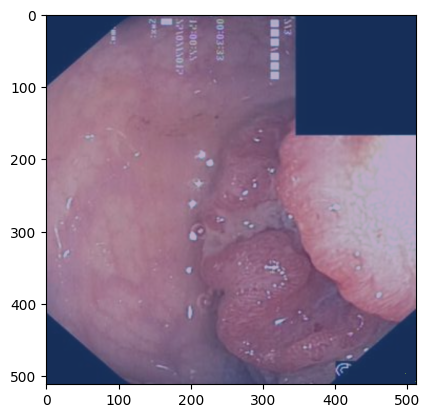

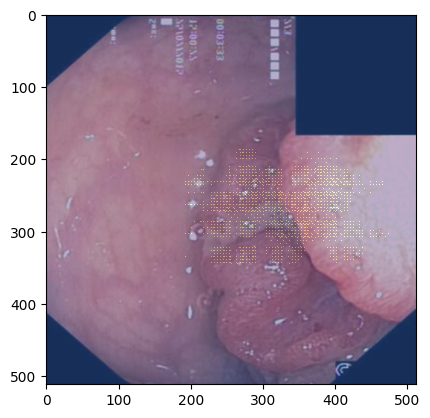

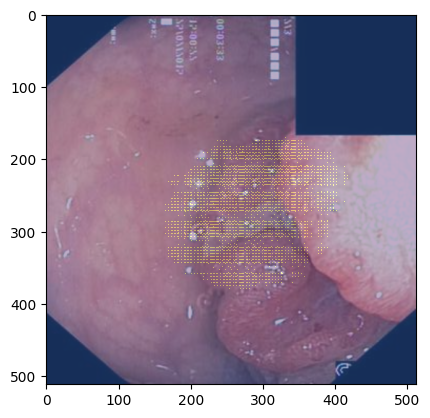

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
dice_loss_criterion = monai.losses.DiceLoss(to_onehot_y=True, softmax=True, squared_pred=False)
ce_loss_criterion = nn.CrossEntropyLoss(reduction='none')
meta_loss_criterion = nn.L1Loss()
post_label = monai.transforms.AsDiscrete(to_onehot=2)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=2)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
dice_metric_val = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 200
total_prints = 200
print_every_n_epochs = epochs // total_prints
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

'''
with torch.no_grad():
    _, enc_out, _ = model(example_inputs.unsqueeze(0).to(device), oracle_labels_multires)
    print("Number of tokens after encoder: {}".format(enc_out.shape[1]))
'''

for e in range(epochs):
    epoch_start = time.time()
    for i, batch in enumerate(data_loader_train):
        batch_start = time.time()
        inputs, labels = (batch["image"], batch["label"])
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs, _, patches_scale_coords, meta_losses, meta_losses_coords = model(inputs)
        dice_loss = dice_loss_criterion(outputs, labels)
        ce_loss = ce_loss_criterion(outputs, labels.squeeze(1).long())
        dice_ce_loss = dice_loss + ce_loss.mean()
        loss = dice_ce_loss
        if len(meta_losses) > 0:
            meta_loss = compute_meta_loss(ce_loss.detach(), meta_losses, meta_losses_coords, meta_loss_criterion,
                                          patch_sizes_used)
            meta_loss = meta_loss * 5
            loss = loss + meta_loss
        else:
            meta_loss = torch.tensor([0])
        loss = loss / grad_accum_steps
        loss.backward()

        if (i + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        labels_convert = [post_label(labels[0])]
        output_convert = [post_pred(outputs[0])]
        dice_metric(y_pred=output_convert, y=labels_convert)
        batch_time = time.time() - batch_start
    dice_scores, dice_not_nans = dice_metric.aggregate()
    epoch_time = time.time() - epoch_start
    if ((e + 1) % print_every_n_epochs) == 0:
        print("Train Epoch: {}, Dice score: {:.4f}, dice_ce_loss: {:.4f}, meta_loss: {:.4f}, lr: {:.4f}, epoch_time: {:.4f}".format(e, dice_scores.item(), dice_ce_loss.item(), meta_loss.item(), scheduler.get_last_lr()[0], epoch_time))
        #pred = torch.argmax(outputs, dim=1)
        #visualize_data(inputs, pred)
        with torch.no_grad():
            for i, batch in enumerate(data_loader_val):
                inputs, labels = (batch["image"], batch["label"])
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs, _, patches_scale_coords, meta_losses, meta_losses_coords = model(inputs)
                labels_convert = [post_label(labels[0])]
                output_convert = [post_pred(outputs[0])]
                dice_metric_val(y_pred=output_convert, y=labels_convert)
            dice_scores_val, dice_not_nans_val = dice_metric_val.aggregate()
            print("Validation - Dice score: {:.4f}".format(dice_scores_val.item()))
        pred = torch.argmax(outputs, dim=1).squeeze()
        visualize_data(inputs[0].squeeze(), pred[0])
    scheduler.step()


In [ ]:
visualize_data(inputs.squeeze(), labels.squeeze())
#for ol in oracle_labels_multires:
#    visualize_data(None, ol.squeeze())

In [ ]:
visualize_patches_scale(patches_scale_coords, len(n_encoder_layers), patch_size, image_size, inputs.squeeze())